# Random Forests

## Celdas preparatorias

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

import matplotlib.pyplot as plt
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "11_RF"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
# import warnings
# warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
# Let us define a couple of useful functions (if in colab, otherwise, take from utils module)
if 'google.colab' in sys.modules:

    def plot_clasi(x, t, ws, labels=[], xp=[-1., 1.], thr=[0,], spines='zero', equal=True, 
                   join_centers=False, margin=None):
        """
        Figura con el resultado del ajuste lineal
        """
        assert len(labels) == len(ws) or len(labels) == 0
        assert len(ws) == len(thr)

        if margin is None:
            margin = [False] * len(ws)
        else:    
            margin = np.atleast_1d(margin)
        assert len(margin) == len(ws)

        if len(labels) == 0:
            labels = np.arange(len(ws)).astype('str')

        # Agregemos el vector al plot
        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(111)

        xc1 = x[t == np.unique(t).max()]
        xc2 = x[t == np.unique(t).min()]

        ax.plot(*xc1.T, 'ob', mfc='None', label='C1')
        ax.plot(*xc2.T, 'or', mfc='None', label='C2')

        for i, w in enumerate(ws):

            # Compute vector norm
            wnorm = np.sqrt(np.sum(w**2))

            # Ploteo vector de pesos
            x0 = 0.5 * (xp[0] + xp[1])
            ax.quiver(0, thr[i]/w[1], w[0]/wnorm, w[1]/wnorm, 
                      color='C{}'.format(i+2), scale=10, label=labels[i], 
                      zorder=10)

            # ploteo plano perpendicular
            xp = np.array(xp)
            yp = (thr[i] - w[0]*xp)/w[1] 

            plt.plot(xp, yp, '-', color='C{}'.format(i+2))

            # Plot margin
            if margin[i]:
                for marg in [-1, 1]:
                    ym = yp + marg/w[1]
                    plt.plot(xp, ym, ':', color='C{}'.format(i+2))


        if join_centers:
            # Ploteo línea que une centros de los conjuntos
            mu1 = xc1.mean(axis=1)
            mu2 = xc2.mean(axis=1)
            ax.plot([mu1[0], mu2[0]], [mu1[1], mu2[1]], 'o:k', mfc='None', ms=10)    

        ax.legend(loc=0, fontsize=12)
        if equal:
            ax.set_aspect('equal')

        if spines is not None:
            for a in ['left', 'bottom']:
                ax.spines[a].set_position('zero')
            for a in ['top', 'right']:
                ax.spines[a].set_visible(False)

        return


    def makew(fitter):

        # # Obtengamos los pesos y normalicemos
        w = fitter.coef_.copy()

        # # Incluye intercept
        if fitter.fit_intercept:
            w = np.hstack([fitter.intercept_.reshape(1,1), w])

        # # Normalizon
        #w /= np.linalg.norm(w)
        return w.T
else:
  from utils import plot_clasi
#Utility form A. Gèron
def plot_decision_regions(clf, X, t, axes=None, npointsgrid=500, legend=False, 
                          plot_training=True, 
                          figkwargs={'figsize': [12, 8]}, 
                          contourkwargs={'alpha':0.3}):
    """
    Plot decision regions produced by classifier.

    :param Classifier clf: sklearn classifier supporting XXX
    """

    fig = plt.figure(**figkwargs)
    ax = fig.add_subplot(111)

    if axes is None:
        dx = X[:, 0].max() - X[:, 0].min()
        dy = X[:, 1].max() - X[:, 1].min()
        axes = [X[:, 0].min() - 0.1*dx, X[:, 0].max() + 0.1*dx, 
                X[:, 1].min() - 0.1*dy, X[:, 1].max() + 0.1*dy]
        
    # Define grid for regions
    x1s = np.linspace(axes[0], axes[1], npointsgrid)
    x2s = np.linspace(axes[2], axes[3], npointsgrid)
    x1, x2 = np.meshgrid(x1s, x2s)

    # Make predictions on points of grid; reshape to grid format
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    #custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    ax.contourf(x1, x2, y_pred, **contourkwargs)

#     custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
#         plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)

    if plot_training:
        for label in np.unique(t):
            ax.plot(X[:, 0][t==label], X[:, 1][t==label], "o", label="C{}".format(label))

    # Axis
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

    if legend:
        plt.legend(loc="lower right", fontsize=14)

    plt.show()
    return fig
    
    


## Preparación del Moons dataset

Usemos de nuevo la función `make_moons` para generar un dataset no linealmente separable en dos dimensiones (para poder plotear).

In [22]:
from sklearn.datasets import make_moons
X, t = make_moons(n_samples=400, noise=0.25, random_state=1234)

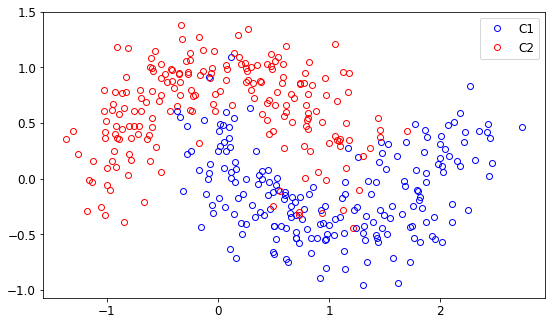

In [23]:
plot_clasi(X, t, [], [], [], [], spines=None)

In [6]:
from sklearn.model_selection import train_test_split

# Split
X, X_test, t, t_test = train_test_split(X, t, test_size=0.2)

## Entrenamiento simple de un Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=6)
rf.fit(X, t)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

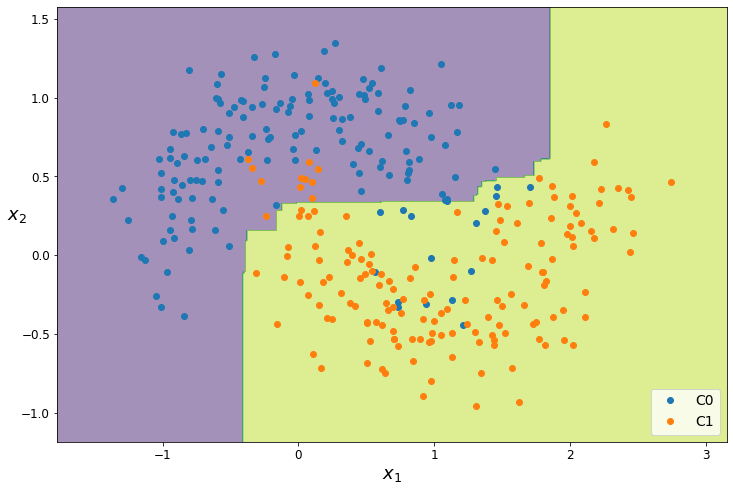

In [9]:
fig = plot_decision_regions(rf, X, t, legend=True, npointsgrid=500, 
                            figkwargs={'figsize': [12, 8]}, 
                            contourkwargs={'alpha':0.5, 'levels':5, 'cmap':'viridis'})

**Claramente es un modelo que no generaliza bien**

In [10]:
from sklearn.metrics import accuracy_score

y_train = rf.predict(X)
y_test = rf.predict(X_test)
print('Accuracy (train): {:.3f}'.format(accuracy_score(t, y_train)))
print('Accuracy (test): {:.3f}'.format(accuracy_score(t_test, y_test)))

Accuracy (train): 0.912
Accuracy (test): 0.875


## Su turno!

Divídanse en grupos y:

__Parte 1__

* Separen el dataset en train y test.
* Entrenen un `DecistionTreeClassifier` usando Cross-Validation para encontrar los mejores hiperparámetros. 
* Guarden los mejores, analicen cuales son los más relevantes para explorar (elijan no más de tres).
* Entrenen un `RandomForestClassifier` en el mismo dataset. 
* Nuevamente, usando CV encuentren los mejores hiperparámetros.

**Tip**: Recuerden que más allá de los de los parámetros del punto anterior, necesitaran optimizar `n_estimators`;

**Tip2**: coffee break.

* Comparen los hiperparámetros obtenidos con cada método. Les encuentran sentido? que opinan?


Compare the hyperparameters obtained with each method. Can you make sense of what you get? 
* Definan un árbol de decisión con los parámetros optimizados para el random forest. Entrénenlo y evaluen su performance en el conjunto de testeo. ¿Qué ven?¿tiene sentido?

**Note:** En todas las instancias usen la función `plot_trees` para ver los resultados.

__Parte 2__

* Usen Random Forests en datasets más grandes como California y MNIST.
* Evaluate the feature importances in each case.

***

In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Árbol Salvaje (sin restricciones)

### Árbol regularizado

In [ ]:
param_grid = {'param1': ...,
              'param2': ...,
              ...
             }

gscv_dt = GridSearchCV(..., ..., ...)

### Random Forest

### Entrenar DT parámetros del RF

## Datasets más grandes

###  Regresión; volviendo a California

In [12]:
HOUSING_PATH = "datasets"

In [13]:
if 'google.colab' in sys.modules:
        
    import tarfile

#     DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/"
#     HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
    DOWNLOAD_ROOT = "https://github.com/IAI-UNSAM/datasets/raw/master/"
    HOUSING_URL = DOWNLOAD_ROOT + "housing/housing_pp_"

    def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
        os.makedirs(housing_path, exist_ok=True)
        for tt in ['train', 'test']:
            full_path = housing_url + tt + '.csv'
            !wget {full_path} -P {housing_path}
            
    # Corramos la función
    fetch_housing_data()

else: 
    print("Not running on Google Colab. This cell is did not do anything.")

--2021-05-20 02:40:17--  https://github.com/IAI-UNSAM/datasets/raw/master/housing/housing_pp_train.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IAI-UNSAM/datasets/master/housing/housing_pp_train.csv [following]
--2021-05-20 02:40:18--  https://raw.githubusercontent.com/IAI-UNSAM/datasets/master/housing/housing_pp_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3070968 (2.9M) [text/plain]
Saving to: ‘datasets/housing_pp_train.csv’

housing_pp_train.cs 100%[===================>]   2.93M  --.-KB/s    in 0.07s   

2021-05-20 02:40:18 (43.0 MB/s) - ‘datasets/housing_pp_train.csv’ sav

In [14]:
import pandas as pd

def load_preprocessed_housing_data(housing_path=HOUSING_PATH, kind='train'):
    assert kind in ['train', 'test'], "kind must be 'train' or 'test'"
    
    csv_path = os.path.join(housing_path, "housing_pp_{}.csv".format(kind))
    return pd.read_csv(csv_path)

# The function loads the data as a Pandas DataFrame instance.
housing_train = load_preprocessed_housing_data(kind='train')
housing_test = load_preprocessed_housing_data(kind='test')

In [15]:
housing_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14856 entries, 0 to 14855
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   longitude               14856 non-null  float64
 1   latitude                14856 non-null  float64
 2   housing_median_age      14856 non-null  float64
 3   total_rooms             14856 non-null  float64
 4   total_bedrooms          14856 non-null  float64
 5   population              14856 non-null  float64
 6   households              14856 non-null  float64
 7   median_income           14856 non-null  float64
 8   bedrooms_per_rooms      14856 non-null  float64
 9   bedrooms_per_household  14856 non-null  float64
 10  median_house_value      14856 non-null  float64
dtypes: float64(11)
memory usage: 1.2 MB


In [16]:
# Predictor variables (in a matrix, as required by sklearn)
X = housing_train.drop('median_house_value', axis=1, inplace=False)
t = housing_train.median_house_value.values

X_test = housing_test.drop('median_house_value', axis=1, inplace=False)
t_test = housing_test.median_house_value.values

print(X.shape, t.shape)

(14856, 10) (14856,)


In [17]:
from sklearn.ensemble import RandomForestRegressor


###  Clasificación; MNIST

In [20]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [21]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'plasma',
               interpolation="nearest")
    plt.axis("off")